<a id='top'></a>

### 演習15）

この演習では，任意の化学組成が形成する三つの構造クラス(準結晶（QC）・近似結晶（AC）・通常の周期結晶（others）)を判別するモデルを構築する．

この演習は一定数の結晶データが必要になる．[retrieve_materials_project](https://nbviewer.org/github/yoshida-lab/XenonPy/blob/master/MI_Book/retrieve_materials_project.ipynb)を参考してサンプルデータを用意せよ．

In [30]:
%run common_setting.ipynb

import pandas as pd
import numpy as np

from xenonpy.datatools import preset

#### 訓練データ

モデルを訓練するために，まず準結晶（QC），近似結晶（AC）とそれ以外（others）の組成データを読み込む．

In [15]:
quasi = pd.read_pickle('data/QC_AC_data.pd.xz')  # 準結晶・近似結晶データ
crystal = preset.mp_samples  # 準結晶・近似結晶データ
crystal = crystal[['composition']].assign(label='others')

quasi
crystal

,composition,label
formula,,
Cr 5 Ni 3 Si 2,"{'Cr': 5.0, 'Ni': 3.0, 'Si': 2.0}",QC
Mn 4 Si 1,"{'Mn': 4.0, 'Si': 1.0}",QC
Mn 82 Si 15 Al 3,"{'Mn': 82.0, 'Si': 15.0, 'Al': 3.0}",QC
Zn 58 Mg 40 Dy 2,"{'Zn': 58.0, 'Mg': 40.0, 'Dy': 2.0}",QC
Zn 58 Mg 40 Er 2,"{'Zn': 58.0, 'Mg': 40.0, 'Er': 2.0}",QC
...,...,...
Au 61.2 Sn 24.5 Eu 14.3,"{'Au': 61.2, 'Sn': 24.5, 'Eu': 14.3}",AC
Ag 41 In 44 Yb 15,"{'Ag': 41.0, 'In': 44.0, 'Yb': 15.0}",AC
Ag 42 In 45 Ca 13,"{'Ag': 42.0, 'In': 45.0, 'Ca': 13.0}",AC


,composition,label
mp-1013558,"{'Ca': 3.0, 'Bi': 1.0, 'P': 1.0}",others
mp-1018025,"{'Lu': 1.0, 'Ag': 1.0, 'O': 2.0}",others
mp-1019105,"{'K': 2.0, 'Mg': 2.0, 'Bi': 2.0}",others
mp-1020108,"{'Li': 2.0, 'Ca': 2.0, 'Mg': 2.0, 'Si': 2.0, '...",others
mp-1029828,"{'Rb': 8.0, 'Cr': 8.0, 'N': 16.0}",others
...,...,...
mp-976578,"{'Nd': 6.0, 'H': 18.0}",others
mp-9856,"{'Cs': 4.0, 'Zr': 2.0, 'Se': 6.0}",others
mp-985829,"{'Hf': 1.0, 'S': 2.0}",others
mp-989541,"{'Rb': 2.0, 'Na': 1.0, 'Sb': 1.0, 'F': 6.0}",others


#### 組成記述子を計算する

演習12）述べたように，`xenonpy.descriptor.Compositions`を用いて記述子を計算する．

In [16]:
from xenonpy.descriptor import Compositions

Compositions?

Init signature:
Compositions(
    *,
    elemental_info: Union[pandas.core.frame.DataFrame, NoneType] = None,
    n_jobs: int = -1,
    featurizers: Union[str, List[str]] = 'classic',
    on_errors: str = 'nan',
)
Docstring:      Calculate elemental descriptors from compound's composition.
Init docstring:
Parameters
----------
elemental_info
    Elemental level information for each element. For example, the ``atomic number``,
    ``atomic radius``, and etc. By default (``None``), will use the XenonPy embedded information.
n_jobs: int
    The number of jobs to run in parallel for both fit and predict.
    Set -1 to use all cpu cores (default).
    Inputs ``X`` will be split into some blocks then run on each cpu cores.
featurizers: Union[str, List[str]]
    Name of featurizers that will be used.
    Set to `classic` to be compatible with the old version.
    This is equal to set ``featurizers=['WeightedAverage', 'WeightedSum',
    'WeightedVariance', 'MaxPooling', 'MinPooling']``.
    De

まずはQC，ACとothersのデータを合併する．

In [17]:
training_data = pd.concat([quasi, crystal])
training_data.sample(3)

,composition,label
mp-989555,"{'Tl': 2.0, 'In': 1.0, 'Ga': 1.0, 'F': 6.0}",others
Al 71.5 Cu 8.5 Ru 20,"{'Al': 71.5, 'Cu': 8.5, 'Ru': 20.0}",AC
mp-30056,"{'Cs': 1.0, 'Ca': 1.0, 'Br': 3.0}",others


教科書で説明したように，QC・ACデータの組成式は原子総数が100になっていると比べ，othersの組成式の原子総数にかなりのバラツキがある．このバラツキに影響しない`WeightedAverage`, `WeightedVariance`, `MaxPooling`と`MinPooling`記述子のみ採用する．

下記計算数分かかる場合もある．

In [18]:
%%time

featurizers = ['WeightedAverage', 'WeightedVariance', 'MaxPooling', 'MinPooling']

compositions = Compositions(featurizers=featurizers)  # use specific featurizers
comp_desc = compositions.fit_transform(training_data)
comp_desc

CPU times: user 1.93 s, sys: 624 ms, total: 2.55 s
Wall time: 9.64 s


,ave:atomic_number,ave:atomic_radius,ave:atomic_radius_rahm,ave:atomic_volume,ave:atomic_weight,ave:boiling_point,ave:bulk_modulus,ave:c6_gb,ave:covalent_radius_cordero,ave:covalent_radius_pyykko,...,min:num_s_valence,min:period,min:specific_heat,min:thermal_conductivity,min:vdw_radius,min:vdw_radius_alvarez,min:vdw_radius_mm3,min:vdw_radius_uff,min:sound_velocity,min:Polarizability
Cr 5 Ni 3 Si 2,23.200000,128.600000,228.600000,8.015000,49.223070,2899.600000,154.000000,534.000000,128.900000,117.200000,...,1.0,3.0,0.443,91.0000,197.0,219.0,222.0,283.4,2200.000000,5.530000
Mn 4 Si 1,22.800000,134.400000,240.000000,8.332000,49.567435,2313.600000,116.000000,569.600000,142.200000,118.400000,...,2.0,3.0,0.477,7.8000,205.0,219.0,224.0,296.1,2200.000000,5.530000
Mn 82 Si 15 Al 3,22.990000,134.790000,240.410000,8.174800,50.071392,2309.100000,115.680000,582.500000,143.280000,118.760000,...,2.0,3.0,0.477,7.8000,184.0,219.0,224.0,296.1,2200.000000,5.530000
Zn 58 Mg 40 Dy 2,23.520000,147.640000,230.260000,11.316000,50.892400,1286.300000,59.420000,460.280000,131.000000,127.380000,...,2.0,3.0,0.173,11.0000,173.0,239.0,229.0,276.3,2710.000000,5.750000
Zn 58 Mg 40 Er 2,23.560000,147.600000,230.200000,11.304000,50.987580,1292.320000,59.480000,454.680000,130.940000,127.340000,...,2.0,3.0,0.168,15.0000,173.0,239.0,229.0,276.3,2830.000000,5.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mp-976578,15.750000,104.750000,186.500000,15.725000,36.816500,850.460000,50.599730,894.882500,73.500000,67.500000,...,1.0,1.0,0.205,0.1805,110.0,120.0,162.0,288.6,1270.000000,0.666793
mp-9856,42.000000,185.666667,239.666667,33.933333,98.991317,1571.250000,33.436636,2563.166667,170.500000,161.000000,...,1.0,4.0,0.241,0.5200,190.0,182.0,229.0,312.4,2177.277969,3.770000
mp-985829,34.666667,140.333333,230.666667,14.866667,80.870000,2301.882667,41.800000,440.000000,128.333333,119.333333,...,2.0,3.0,0.146,0.2050,180.0,189.0,215.0,314.1,3010.000000,2.900000
mp-989541,19.000000,164.914169,192.900000,25.650000,42.967579,549.616000,33.409364,1145.520000,108.700000,109.900000,...,1.0,2.0,0.205,0.0277,147.0,146.0,171.0,298.3,1300.000000,0.557000


#### モデルを訓練する

これから，用意されたデータを`xenonpy.datatools.Splitter`を用いて訓練データとテストデータに分けてモデルを訓練する．

In [19]:
from xenonpy.datatools import Splitter
Splitter?

Init signature:
Splitter(
    size: int,
    *,
    test_size: Union[float, int] = 0.2,
    k_fold: Union[int, Iterable, NoneType] = None,
    random_state: Union[int, NoneType] = None,
    shuffle: bool = True,
)
Docstring:      Data splitter for train and test
Init docstring:
Parameters
----------
size
    Total sample size.
    All data must have same length of their first dim,
test_size
    If float, should be between ``0.0`` and ``1.0`` and represent the proportion
    of the dataset to include in the test split. If int, represents the
    absolute number of test samples. Can be ``0`` if cv is ``None``.
    In this case, :meth:`~Splitter.cv` will yield a tuple only contains ``training`` and ``validation``
    on each step. By default, the value is set to 0.2.
k_fold
    Number of k-folds.
    If ``int``, Must be at least 2.
    If ``Iterable``, it should provide label for each element which will be used for group cv.
    In this case, the input of :meth:`~Splitter.cv` must be a :c

In [20]:
splitter = Splitter(size=comp_desc.shape[0], random_state=0, test_size=0.3)
splitter

Splitter(random_state=0, size=2158, test_size=0.3)

In [21]:
x_train, x_test, y_train, y_test = splitter.split(comp_desc, training_data.label)

x_train.shape
y_train.shape
x_test.shape
y_test.shape

(1510, 232)

(1510,)

(648, 232)

(648,)

#### ランダムフォレスト分類器

この演習では，ハイパーパラメータのチューニングをしないようにしている．ハイパーパラメータのチューニングについて，[公式サイト](https://scikit-learn.org/stable/modules/grid_search.html) を参考してください．

In [22]:
# import the library for random forest
from sklearn.ensemble import RandomForestClassifier

# prepare the random forest class
rfc = RandomForestClassifier(
    n_estimators=200,
    max_depth=25,
    max_features="log2",
    bootstrap=False,
    criterion="entropy",
    n_jobs=1, 
    random_state=0
)
rfc

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=25,
                       max_features='log2', n_estimators=200, n_jobs=1,
                       random_state=0)

In [23]:
# train the model with training data
rfc.fit(x_train, y_train)

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=25,
                       max_features='log2', n_estimators=200, n_jobs=1,
                       random_state=0)

In [24]:
# predict the label of test data
y_pred = rfc.predict(x_test)
y_pred

array(['others', 'others', 'others', 'others', 'others', 'others',
       'others', 'others', 'others', 'AC', 'others', 'others', 'others',
       'QC', 'others', 'others', 'others', 'others', 'others', 'others',
       'others', 'others', 'others', 'others', 'others', 'QC', 'others',
       'others', 'others', 'others', 'others', 'others', 'AC', 'others',
       'others', 'others', 'others', 'others', 'others', 'others',
       'others', 'others', 'others', 'others', 'others', 'others',
       'others', 'others', 'others', 'others', 'others', 'others',
       'others', 'others', 'others', 'others', 'others', 'others',
       'others', 'others', 'others', 'others', 'others', 'others',
       'others', 'others', 'others', 'others', 'others', 'others', 'AC',
       'others', 'others', 'others', 'others', 'QC', 'others', 'others',
       'others', 'others', 'others', 'others', 'others', 'others',
       'others', 'others', 'others', 'others', 'others', 'others',
       'others', 'others',

### confusion matrixでモデル性能を可視化

https://en.wikipedia.org/wiki/Confusion_matrix

In [25]:
# import a library for evaluating the model performance based on confusion matrix
from sklearn.metrics import confusion_matrix

labels = ['others', 'QC', 'AC']
confusion_matrix = confusion_matrix(y_test, y_pred, labels=labels)
confusion_matrix

array([[595,   0,   0],
       [  0,  16,   7],
       [  0,  10,  20]])

Text(0.5, 1.0, 'Normalized confusion matrix')

Text(0.5, 1.0, 'Without normalize')

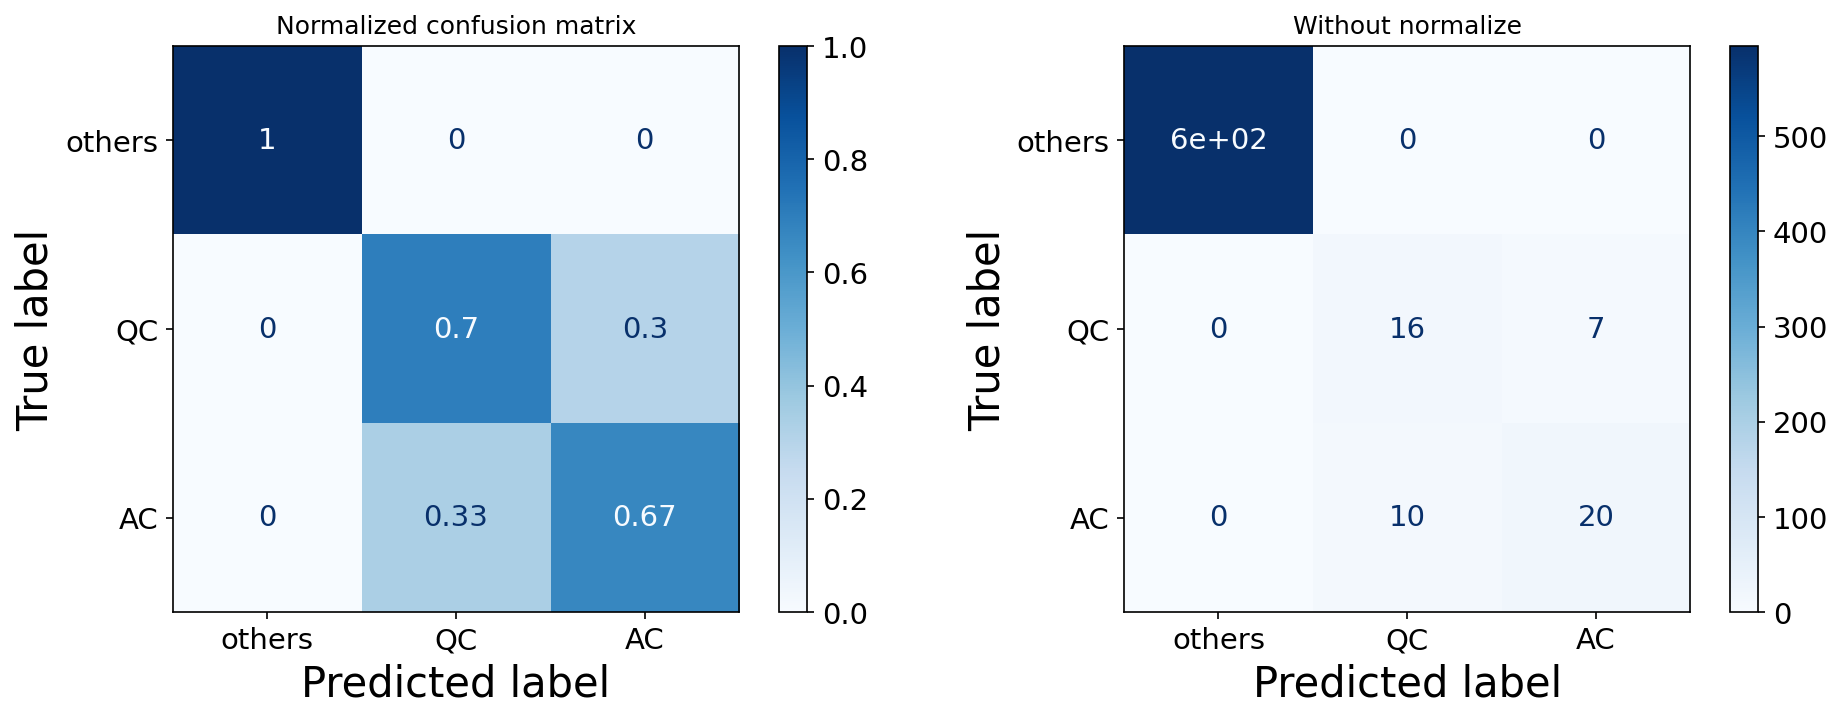

In [32]:
from matplotlib import pyplot as plt

# plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)
cm = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
cmd = ConfusionMatrixDisplay(cm, labels)
cmd.plot(
    cmap=plt.cm.Blues, 
    ax=ax1)
ax1.set_title("Normalized confusion matrix")

cmd = ConfusionMatrixDisplay(confusion_matrix, labels)
cmd.plot(
    cmap=plt.cm.Blues, 
    ax=ax2)
ax2.set_title("Without normalize")